In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pr2_utils import *
from prediction import prediction


'''
    variable declaration
    Lidar to Body Transformation provided values
    Lidar Parameters
    Other Variable Definition
    
'''
rpy = np.array([[142.759,0.0584636, 89.9254]])
r_l2b = np.array([[0.00130201, 0.796097 ,0.605167],[0.999999, -0.000419027, -0.00160026],[-0.00102038 ,0.605169 ,-0.796097 ]])
t_l2b = np.array([[0.8349 , -0.0126869 , 1.76416]])

fov = 190
start_angle = -5
end_angle = 185
angular_resolution = 0.666
max_range = 80


def lidar_data_process(lidar_data, particle_state):


    coord = list()
    angle = 0
    x_s_0 = np.zeros(286)
    y_s_0 = np.zeros(286)

    '''
        x, y coordinates are calculated from lidar data
    
    '''
    for i in range(len(lidar_data)):
        angle = start_angle + (i*angular_resolution)
        a = [0,0]
        
        '''
        lidar data is filtered with the range 2<d<75

        '''

        if lidar_data[i] > 2 and lidar_data[i] < 75:
            a[0] = lidar_data[i] * (np.cos(np.deg2rad(angle)))
            a[1] = lidar_data[i] * (np.sin(np.deg2rad(angle)))
            coord.append(a)

    '''
    convereted to lidar to world frame
    pose matrix is formed from lidar to body frame transfromation
    
    '''

    pose_l2b = np.concatenate((r_l2b, t_l2b.T), axis = 1)
    pose_l2b = np.concatenate((pose_l2b, np.array([[0,0,0,1]])), axis = 0)

    theta = particle_state[2]

    '''
    pose matrix is formed from body to world frame transfromation
    '''

    r_b2w = np.array([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta), np.cos(theta), 0],[0, 0, 1]])


    pose_b2w = np.concatenate((r_b2w, np.array([[particle_state[0], particle_state[1], 0]]).T), axis = 1)
    pose_b2w = np.concatenate((pose_b2w, np.array([[0,0,0,1]])), axis = 0)

    '''
    final pose formulated for lidar to world frame transformation

    '''

    pose = np.dot(pose_b2w, pose_l2b)


    for i in range(len(coord)):
        a = [coord[i][0], coord[i][1], 0, 1 ]
        a = np.dot(pose, a)
        x_s_0[i] = a[0]
        y_s_0[i] = a[1]

    x_s_0 = x_s_0[x_s_0 != 0]
    y_s_0 = y_s_0[y_s_0 != 0]

    return  x_s_0, y_s_0



In [5]:

import numpy as np
import matplotlib.pyplot as plt
from pr2_utils import *
from lidar_process import lidar_data_process


# Function Definitions

def initialize_Lidar():

    timestamp, data = read_data_from_csv('data/sensor_data/lidar.csv')

    return timestamp, data

def initialize_Encoder():

    timestamp, data = read_data_from_csv('data/sensor_data/encoder.csv')

    return timestamp, data

def initialize_FOG():

    timestamp, data = read_data_from_csv('data/sensor_data/fog.csv')

    return timestamp, data

def sync_Encoder_FOG_Data(_data_fog, _timestamp_encoder):

    _delta_yaw           = np.zeros(116048)
    _dt                  = np.zeros(116048)

    for i in range( len(_timestamp_encoder) - 1 ):
        _delta_yaw[i]    = sum( _data_fog[ ((i - 1)*10 + 1) : (i*10 + 1), 2 ] )
        _dt[i]           = (_timestamp_encoder[i+1] - _timestamp_encoder[i] ) * 10**(-9) # Conversion from nanoseconds to seconds

    return _delta_yaw, _dt

def add_Noise(_particle_state, _particle_count, _dt):

    temp_State_Array = np.zeros((_particle_count, 3))

    for i in range(_particle_count):

        linear_velocity_noise       = np.random.normal(0, 0.5)
        angular_velocity_noise      = np.random.normal(0, 0.05)
        temp_State_Array[i,0]       = _particle_state[i,0] + (linear_velocity_noise * _dt)
        temp_State_Array[i,1]       = _particle_state[i,1] + (linear_velocity_noise * _dt)
        temp_State_Array[i,2]       = _particle_state[i,2] + (angular_velocity_noise * _dt)

    return temp_State_Array


def initialize_Map(MAP):

    MAP['res']      = 1 # Meters
    MAP['xmin']     = -100  # Meters
    MAP['ymin']     = -1200 # Meters
    MAP['xmax']     = 1300 # Meters
    MAP['ymax']     = 100  # Meters
    MAP['sizex']    = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) # Cells
    MAP['sizey']    = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map']      = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.float32)

    _x_im           = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) # x-positions of each pixel of the map
    _y_im           = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) # y-positions of each pixel of the map

    _x_range        = np.arange(-4 * MAP['res'], 5 * MAP['res'], MAP['res'])
    _y_range        = np.arange(-4 * MAP['res'], 5 * MAP['res'], MAP['res'])

    return MAP, _x_im, _y_im, _x_range, _y_range

def calculate_Map_Correlation(_data_lidar, _particle_count, _particle_state, _particle_weights, MAP, _x_im, _y_im, _x_range, _y_range):

    correlation         = np.zeros(_particle_count)
    #im                  = ((1 - 1 / (1 + np.exp(MAP['map']))) > 0.5).astype(np.int)

    for i in range(_particle_count):
        _xs0, _ys0      = lidar_data_process(_data_lidar, _particle_state[i])
        Y               = np.stack((_xs0, _ys0))
        corr            = mapCorrelation(MAP['map'], _x_im, _y_im, Y, _x_range, _y_range)
        correlation[i]  = np.max(corr)

    # Update Particle Weights using Softmax Function
    max_corr                    = np.max(correlation)
    beta                        = np.exp(correlation - max_corr)
    ph                          = beta / beta.sum()
    _particle_weights           = _particle_weights * ( ph / np.sum(_particle_weights * ph) )

    # Find the particle which matches best with the Map
    _position_matched_particle  = np.argmax(_particle_weights)
    _state_matched_particle     = _particle_state[_position_matched_particle, :]

    return _state_matched_particle

def update_Map(MAP, _xs0, _ys0, _particle_state, _log_odds_ratio):

    # convert from meters to cells
    xis             = np.ceil((_xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis             = np.ceil((_ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

    x_origin        = np.ceil((_particle_state[0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    y_origin        = np.ceil((_particle_state[1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

    output = np.zeros((2,0))

    for i in range(len(xis)):
        bresenham_output    = bresenham2D(x_origin, y_origin, xis[i], yis[i])
        output              = np.hstack((output, bresenham_output))

    bresenham_x     = output[0,:].astype(int)
    bresenham_y     = output[1,:].astype(int)

    indGood = np.logical_and(np.logical_and(np.logical_and((bresenham_x > 1), (bresenham_y > 1)), (bresenham_x < MAP['sizex'])), (bresenham_y < MAP['sizey']))

    # Update Map using log-odds ratio

    # Decrease the log-odds for free cells
    MAP['map'][ bresenham_x[indGood] , bresenham_y[indGood] ] += _log_odds_ratio

    # Increase the log-odds for occupied cells
    for i in range(len(xis)):
        if (xis[i] > 1) and (xis[i] < MAP['sizex']) and yis[i] > 1 and (yis[i] < MAP['sizey']):
            MAP['map'][ xis[i] , yis[i] ] -= _log_odds_ratio

    # Clip Map to the maximum and minimum values given
    MAP['map'] = np.clip(MAP['map'], -10*_log_odds_ratio, 10*_log_odds_ratio)

    return MAP

def superimpose_Trajectory(_trajectory, MAP):

    _x        = np.ceil((_trajectory[:,0] - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    _y        = np.ceil((_trajectory[:,1] - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

    return _x, _y

def plot_Map(MAP, _x, _y):
#def plot_Map(MAP):

    #plt.plot(_trajectory[:,0], _trajectory[:,1], color='r', linewidth=1)
    plt.imshow(MAP['map'], cmap='gray')
    # output_map = ((1 - 1 / (1 + np.exp(MAP['map']))) < 0.1).astype(np.int)
    #output_wall = ((1 - 1 / (1 + np.exp(MAP['map']))) > 0.9).astype(np.int)
    # plt.imshow(output_map, cmap = 'gray')
    plt.plot(_y, _x, color='orangered', linewidth=0.5)
    # plt.imsave('Images/' + str('1') + '.png', output_map, cmap='gray')
    # plt.imsave('Images/' + str('2') + '.png', MAP['map'], cmap='gray')
    plt.title("Occupancy Grid Map")
    plt.xlabel("x grid-cell coordinates")
    plt.ylabel("y grid-cell coordinates")

    plt.show(block=True)

    return 0 
        

Lidar Counter: 0


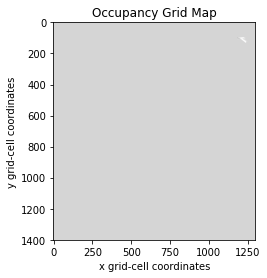

Encoder Counter: 0
Lidar Counter: 5
Encoder Counter: 0
Encoder Counter: 1
Encoder Counter: 2
Encoder Counter: 3
Encoder Counter: 4
Lidar Counter: 5
Encoder Counter: 5
Encoder Counter: 6
Encoder Counter: 7
Encoder Counter: 8
Encoder Counter: 9
Lidar Counter: 10
Encoder Counter: 10
Encoder Counter: 11
Encoder Counter: 12
Encoder Counter: 13
Encoder Counter: 14
Lidar Counter: 15
Encoder Counter: 15
Encoder Counter: 16
Encoder Counter: 17
Encoder Counter: 18
Encoder Counter: 19
Lidar Counter: 20
Encoder Counter: 20
Encoder Counter: 21
Encoder Counter: 22
Encoder Counter: 23
Encoder Counter: 24
Lidar Counter: 25
Encoder Counter: 25
Encoder Counter: 26
Encoder Counter: 27
Encoder Counter: 28
Encoder Counter: 29
Lidar Counter: 30
Encoder Counter: 30
Encoder Counter: 31
Encoder Counter: 32
Encoder Counter: 33
Encoder Counter: 34
Lidar Counter: 35
Encoder Counter: 35
Encoder Counter: 36
Encoder Counter: 37
Encoder Counter: 38
Encoder Counter: 39
Lidar Counter: 40
Encoder Counter: 40
Encoder Cou

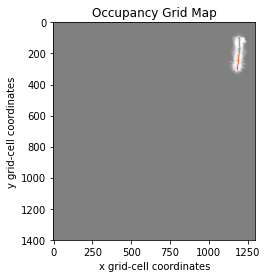

Encoder Counter: 3000
Lidar Counter: 3000
Encoder Counter: 3000
Encoder Counter: 3001
Encoder Counter: 3002
Encoder Counter: 3003
Encoder Counter: 3004
Lidar Counter: 3000
Encoder Counter: 3005
Encoder Counter: 3006
Encoder Counter: 3007
Encoder Counter: 3008
Encoder Counter: 3009
Lidar Counter: 3005
Encoder Counter: 3010
Encoder Counter: 3011
Encoder Counter: 3012
Encoder Counter: 3013
Encoder Counter: 3014
Lidar Counter: 3010
Encoder Counter: 3015
Encoder Counter: 3016
Encoder Counter: 3017
Encoder Counter: 3018
Encoder Counter: 3019
Lidar Counter: 3015
Encoder Counter: 3020
Encoder Counter: 3021
Encoder Counter: 3022
Encoder Counter: 3023
Encoder Counter: 3024
Lidar Counter: 3020
Encoder Counter: 3025
Encoder Counter: 3026
Encoder Counter: 3027
Encoder Counter: 3028
Encoder Counter: 3029
Lidar Counter: 3025
Encoder Counter: 3030
Encoder Counter: 3031
Encoder Counter: 3032
Encoder Counter: 3033
Encoder Counter: 3034
Lidar Counter: 3030
Encoder Counter: 3035
Encoder Counter: 3036
Enco

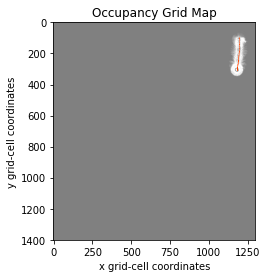

Encoder Counter: 6000
Lidar Counter: 5995
Encoder Counter: 6000
Encoder Counter: 6001
Encoder Counter: 6002
Encoder Counter: 6003
Encoder Counter: 6004
Lidar Counter: 5995
Encoder Counter: 6005
Encoder Counter: 6006
Encoder Counter: 6007
Encoder Counter: 6008
Encoder Counter: 6009
Lidar Counter: 6000
Encoder Counter: 6010
Encoder Counter: 6011
Encoder Counter: 6012
Encoder Counter: 6013
Encoder Counter: 6014
Lidar Counter: 6005
Encoder Counter: 6015
Encoder Counter: 6016
Encoder Counter: 6017
Encoder Counter: 6018
Encoder Counter: 6019
Lidar Counter: 6010
Encoder Counter: 6020
Encoder Counter: 6021
Encoder Counter: 6022
Encoder Counter: 6023
Encoder Counter: 6024
Lidar Counter: 6015
Encoder Counter: 6025
Encoder Counter: 6026
Encoder Counter: 6027
Encoder Counter: 6028
Encoder Counter: 6029
Lidar Counter: 6020
Encoder Counter: 6030
Encoder Counter: 6031
Encoder Counter: 6032
Encoder Counter: 6033
Encoder Counter: 6034
Lidar Counter: 6025
Encoder Counter: 6035
Encoder Counter: 6036
Enco

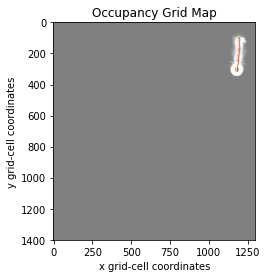

Encoder Counter: 9000
Lidar Counter: 8990
Encoder Counter: 9000
Encoder Counter: 9001
Encoder Counter: 9002
Encoder Counter: 9003
Lidar Counter: 8990
Encoder Counter: 9004
Encoder Counter: 9005
Encoder Counter: 9006
Encoder Counter: 9007
Encoder Counter: 9008
Lidar Counter: 8995
Encoder Counter: 9009
Encoder Counter: 9010
Encoder Counter: 9011
Encoder Counter: 9012
Encoder Counter: 9013
Lidar Counter: 9000
Encoder Counter: 9014
Encoder Counter: 9015
Encoder Counter: 9016
Encoder Counter: 9017
Encoder Counter: 9018
Lidar Counter: 9005
Encoder Counter: 9019
Encoder Counter: 9020
Encoder Counter: 9021
Encoder Counter: 9022
Encoder Counter: 9023
Lidar Counter: 9010
Encoder Counter: 9024
Encoder Counter: 9025
Encoder Counter: 9026
Encoder Counter: 9027
Encoder Counter: 9028
Lidar Counter: 9015
Encoder Counter: 9029
Encoder Counter: 9030
Encoder Counter: 9031
Encoder Counter: 9032
Encoder Counter: 9033
Lidar Counter: 9020
Encoder Counter: 9034
Encoder Counter: 9035
Encoder Counter: 9036
Enco

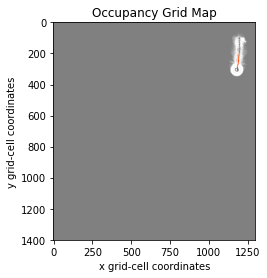

Encoder Counter: 12000
Lidar Counter: 11985
Encoder Counter: 12000
Encoder Counter: 12001
Encoder Counter: 12002
Encoder Counter: 12003
Lidar Counter: 11985
Encoder Counter: 12004
Encoder Counter: 12005
Encoder Counter: 12006
Encoder Counter: 12007
Encoder Counter: 12008
Lidar Counter: 11990
Encoder Counter: 12009
Encoder Counter: 12010
Encoder Counter: 12011
Encoder Counter: 12012
Encoder Counter: 12013
Lidar Counter: 11995
Encoder Counter: 12014
Encoder Counter: 12015
Encoder Counter: 12016
Encoder Counter: 12017
Encoder Counter: 12018
Lidar Counter: 12000
Encoder Counter: 12019
Encoder Counter: 12020
Encoder Counter: 12021
Encoder Counter: 12022
Encoder Counter: 12023
Lidar Counter: 12005
Encoder Counter: 12024
Encoder Counter: 12025
Encoder Counter: 12026
Encoder Counter: 12027
Encoder Counter: 12028
Lidar Counter: 12010
Encoder Counter: 12029
Encoder Counter: 12030
Encoder Counter: 12031
Encoder Counter: 12032
Encoder Counter: 12033
Lidar Counter: 12015
Encoder Counter: 12034
Enco

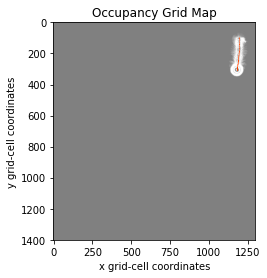

Encoder Counter: 15000
Lidar Counter: 14980
Encoder Counter: 15000
Encoder Counter: 15001
Encoder Counter: 15002
Encoder Counter: 15003
Lidar Counter: 14980
Encoder Counter: 15004
Encoder Counter: 15005
Encoder Counter: 15006
Encoder Counter: 15007
Encoder Counter: 15008
Lidar Counter: 14985
Encoder Counter: 15009
Encoder Counter: 15010
Encoder Counter: 15011
Encoder Counter: 15012
Encoder Counter: 15013
Lidar Counter: 14990
Encoder Counter: 15014
Encoder Counter: 15015
Encoder Counter: 15016
Encoder Counter: 15017
Lidar Counter: 14995
Encoder Counter: 15018
Encoder Counter: 15019
Encoder Counter: 15020
Encoder Counter: 15021
Encoder Counter: 15022
Encoder Counter: 15023
Lidar Counter: 15000
Encoder Counter: 15024
Encoder Counter: 15025
Encoder Counter: 15026
Encoder Counter: 15027
Encoder Counter: 15028
Lidar Counter: 15005
Encoder Counter: 15029
Encoder Counter: 15030
Encoder Counter: 15031
Encoder Counter: 15032
Encoder Counter: 15033
Lidar Counter: 15010
Encoder Counter: 15034
Enco

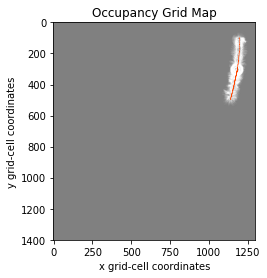

Encoder Counter: 18000
Lidar Counter: 17975
Encoder Counter: 18000
Encoder Counter: 18001
Encoder Counter: 18002
Lidar Counter: 17975
Encoder Counter: 18003
Encoder Counter: 18004
Encoder Counter: 18005
Encoder Counter: 18006
Encoder Counter: 18007
Lidar Counter: 17980
Encoder Counter: 18008
Encoder Counter: 18009
Encoder Counter: 18010
Encoder Counter: 18011
Encoder Counter: 18012
Lidar Counter: 17985
Encoder Counter: 18013
Encoder Counter: 18014
Encoder Counter: 18015
Encoder Counter: 18016
Encoder Counter: 18017
Lidar Counter: 17990
Encoder Counter: 18018
Encoder Counter: 18019
Encoder Counter: 18020
Encoder Counter: 18021
Encoder Counter: 18022
Lidar Counter: 17995
Encoder Counter: 18023
Encoder Counter: 18024
Encoder Counter: 18025
Encoder Counter: 18026
Encoder Counter: 18027
Lidar Counter: 18000
Encoder Counter: 18028
Encoder Counter: 18029
Encoder Counter: 18030
Encoder Counter: 18031
Encoder Counter: 18032
Lidar Counter: 18005
Encoder Counter: 18033
Encoder Counter: 18034
Enco

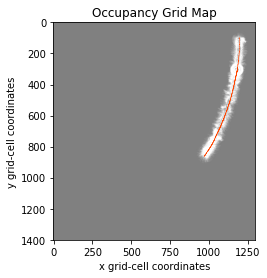

Encoder Counter: 21000
Lidar Counter: 20970
Encoder Counter: 21000
Encoder Counter: 21001
Encoder Counter: 21002
Lidar Counter: 20970
Encoder Counter: 21003
Encoder Counter: 21004
Encoder Counter: 21005
Encoder Counter: 21006
Encoder Counter: 21007
Lidar Counter: 20975
Encoder Counter: 21008
Encoder Counter: 21009
Encoder Counter: 21010
Encoder Counter: 21011
Encoder Counter: 21012
Lidar Counter: 20980
Encoder Counter: 21013
Encoder Counter: 21014
Encoder Counter: 21015
Encoder Counter: 21016
Encoder Counter: 21017
Lidar Counter: 20985
Encoder Counter: 21018
Encoder Counter: 21019
Encoder Counter: 21020
Encoder Counter: 21021
Encoder Counter: 21022
Lidar Counter: 20990
Encoder Counter: 21023
Encoder Counter: 21024
Encoder Counter: 21025
Encoder Counter: 21026
Encoder Counter: 21027
Lidar Counter: 20995
Encoder Counter: 21028
Encoder Counter: 21029
Encoder Counter: 21030
Encoder Counter: 21031
Encoder Counter: 21032
Lidar Counter: 21000
Encoder Counter: 21033
Encoder Counter: 21034
Enco

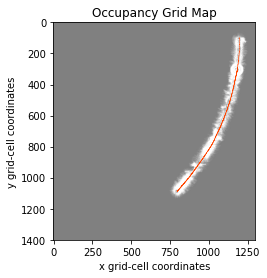

Encoder Counter: 24000
Lidar Counter: 23965
Encoder Counter: 24000
Encoder Counter: 24001
Lidar Counter: 23965
Encoder Counter: 24002
Encoder Counter: 24003
Encoder Counter: 24004
Encoder Counter: 24005
Encoder Counter: 24006
Lidar Counter: 23970
Encoder Counter: 24007
Encoder Counter: 24008
Encoder Counter: 24009
Encoder Counter: 24010
Encoder Counter: 24011
Lidar Counter: 23975
Encoder Counter: 24012
Encoder Counter: 24013
Encoder Counter: 24014
Encoder Counter: 24015
Encoder Counter: 24016
Encoder Counter: 24017
Lidar Counter: 23980
Encoder Counter: 24018
Encoder Counter: 24019
Encoder Counter: 24020
Encoder Counter: 24021
Lidar Counter: 23985
Encoder Counter: 24022
Encoder Counter: 24023
Encoder Counter: 24024
Encoder Counter: 24025
Encoder Counter: 24026
Lidar Counter: 23990
Encoder Counter: 24027
Encoder Counter: 24028
Encoder Counter: 24029
Encoder Counter: 24030
Encoder Counter: 24031
Lidar Counter: 23995
Encoder Counter: 24032
Encoder Counter: 24033
Encoder Counter: 24034
Enco

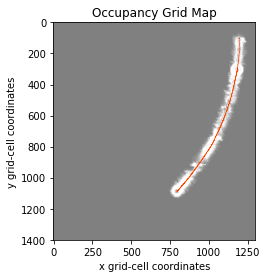

Encoder Counter: 27000
Lidar Counter: 26960
Encoder Counter: 27000
Encoder Counter: 27001
Lidar Counter: 26960
Encoder Counter: 27002
Encoder Counter: 27003
Encoder Counter: 27004
Encoder Counter: 27005
Encoder Counter: 27006
Lidar Counter: 26965
Encoder Counter: 27007
Encoder Counter: 27008
Encoder Counter: 27009
Encoder Counter: 27010
Encoder Counter: 27011
Lidar Counter: 26970
Encoder Counter: 27012
Encoder Counter: 27013
Encoder Counter: 27014
Encoder Counter: 27015
Encoder Counter: 27016
Lidar Counter: 26975
Encoder Counter: 27017
Encoder Counter: 27018
Encoder Counter: 27019
Encoder Counter: 27020
Encoder Counter: 27021
Lidar Counter: 26980
Encoder Counter: 27022
Encoder Counter: 27023
Encoder Counter: 27024
Encoder Counter: 27025
Encoder Counter: 27026
Lidar Counter: 26985
Encoder Counter: 27027
Encoder Counter: 27028
Encoder Counter: 27029
Encoder Counter: 27030
Encoder Counter: 27031
Lidar Counter: 26990
Encoder Counter: 27032
Encoder Counter: 27033
Encoder Counter: 27034
Enco

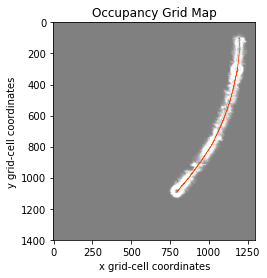

Encoder Counter: 30000
Lidar Counter: 29955
Encoder Counter: 30000
Encoder Counter: 30001
Lidar Counter: 29955
Encoder Counter: 30002
Encoder Counter: 30003
Encoder Counter: 30004
Encoder Counter: 30005
Encoder Counter: 30006
Lidar Counter: 29960
Encoder Counter: 30007
Encoder Counter: 30008
Encoder Counter: 30009
Encoder Counter: 30010
Encoder Counter: 30011
Lidar Counter: 29965
Encoder Counter: 30012
Encoder Counter: 30013
Encoder Counter: 30014
Encoder Counter: 30015
Encoder Counter: 30016
Lidar Counter: 29970
Encoder Counter: 30017
Encoder Counter: 30018
Encoder Counter: 30019
Encoder Counter: 30020
Encoder Counter: 30021
Lidar Counter: 29975
Encoder Counter: 30022
Encoder Counter: 30023
Encoder Counter: 30024
Encoder Counter: 30025
Encoder Counter: 30026
Lidar Counter: 29980
Encoder Counter: 30027
Encoder Counter: 30028
Encoder Counter: 30029
Encoder Counter: 30030
Encoder Counter: 30031
Lidar Counter: 29985
Encoder Counter: 30032
Encoder Counter: 30033
Encoder Counter: 30034
Enco

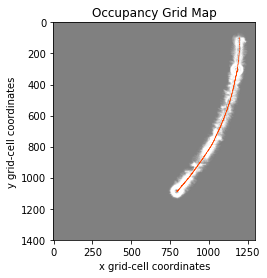

Encoder Counter: 33000
Lidar Counter: 32950
Encoder Counter: 33000
Lidar Counter: 32950
Encoder Counter: 33001
Encoder Counter: 33002
Encoder Counter: 33003
Encoder Counter: 33004
Encoder Counter: 33005
Lidar Counter: 32955
Encoder Counter: 33006
Encoder Counter: 33007
Encoder Counter: 33008
Encoder Counter: 33009
Encoder Counter: 33010
Lidar Counter: 32960
Encoder Counter: 33011
Encoder Counter: 33012
Encoder Counter: 33013
Encoder Counter: 33014
Encoder Counter: 33015
Lidar Counter: 32965
Encoder Counter: 33016
Encoder Counter: 33017
Encoder Counter: 33018
Encoder Counter: 33019
Encoder Counter: 33020
Lidar Counter: 32970
Encoder Counter: 33021
Encoder Counter: 33022
Encoder Counter: 33023
Encoder Counter: 33024
Encoder Counter: 33025
Lidar Counter: 32975
Encoder Counter: 33026
Encoder Counter: 33027
Encoder Counter: 33028
Encoder Counter: 33029
Encoder Counter: 33030
Lidar Counter: 32980
Encoder Counter: 33031
Encoder Counter: 33032
Encoder Counter: 33033
Encoder Counter: 33034
Enco

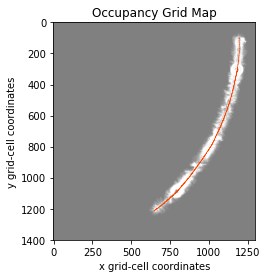

Encoder Counter: 36000
Lidar Counter: 35945
Encoder Counter: 36000
Lidar Counter: 35945
Encoder Counter: 36001
Encoder Counter: 36002
Encoder Counter: 36003
Encoder Counter: 36004
Encoder Counter: 36005
Lidar Counter: 35950
Encoder Counter: 36006
Encoder Counter: 36007
Encoder Counter: 36008
Encoder Counter: 36009
Encoder Counter: 36010
Lidar Counter: 35955
Encoder Counter: 36011
Encoder Counter: 36012
Encoder Counter: 36013
Encoder Counter: 36014
Encoder Counter: 36015
Lidar Counter: 35960
Encoder Counter: 36016
Encoder Counter: 36017
Encoder Counter: 36018
Encoder Counter: 36019
Encoder Counter: 36020
Lidar Counter: 35965
Encoder Counter: 36021
Encoder Counter: 36022
Encoder Counter: 36023
Encoder Counter: 36024
Encoder Counter: 36025
Lidar Counter: 35970
Encoder Counter: 36026
Encoder Counter: 36027
Encoder Counter: 36028
Encoder Counter: 36029
Encoder Counter: 36030
Lidar Counter: 35975
Encoder Counter: 36031
Encoder Counter: 36032
Encoder Counter: 36033
Encoder Counter: 36034
Enco

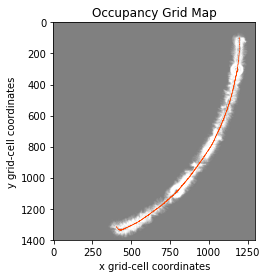

Encoder Counter: 39000
Lidar Counter: 38940
Encoder Counter: 39000
Lidar Counter: 38940
Encoder Counter: 39001
Encoder Counter: 39002
Encoder Counter: 39003
Encoder Counter: 39004
Encoder Counter: 39005
Lidar Counter: 38945
Encoder Counter: 39006
Encoder Counter: 39007
Encoder Counter: 39008
Encoder Counter: 39009
Encoder Counter: 39010
Lidar Counter: 38950
Encoder Counter: 39011
Encoder Counter: 39012
Encoder Counter: 39013
Encoder Counter: 39014
Encoder Counter: 39015
Lidar Counter: 38955
Encoder Counter: 39016
Encoder Counter: 39017
Encoder Counter: 39018
Encoder Counter: 39019
Encoder Counter: 39020
Lidar Counter: 38960
Encoder Counter: 39021
Encoder Counter: 39022
Encoder Counter: 39023
Encoder Counter: 39024
Encoder Counter: 39025
Lidar Counter: 38965
Encoder Counter: 39026
Encoder Counter: 39027
Encoder Counter: 39028
Encoder Counter: 39029
Encoder Counter: 39030
Lidar Counter: 38970
Encoder Counter: 39031
Encoder Counter: 39032
Encoder Counter: 39033
Encoder Counter: 39034
Enco

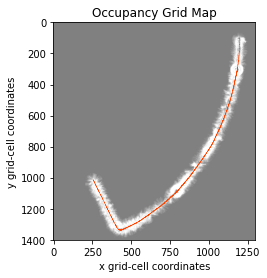

Encoder Counter: 42000
Lidar Counter: 41940
Encoder Counter: 42000
Encoder Counter: 42001
Encoder Counter: 42002
Encoder Counter: 42003
Encoder Counter: 42004
Lidar Counter: 41940
Encoder Counter: 42005
Encoder Counter: 42006
Encoder Counter: 42007
Encoder Counter: 42008
Encoder Counter: 42009
Lidar Counter: 41945
Encoder Counter: 42010
Encoder Counter: 42011
Encoder Counter: 42012
Encoder Counter: 42013
Encoder Counter: 42014
Lidar Counter: 41950
Encoder Counter: 42015
Encoder Counter: 42016
Encoder Counter: 42017
Encoder Counter: 42018
Encoder Counter: 42019
Lidar Counter: 41955
Encoder Counter: 42020
Encoder Counter: 42021
Encoder Counter: 42022
Encoder Counter: 42023
Encoder Counter: 42024
Lidar Counter: 41960
Encoder Counter: 42025
Encoder Counter: 42026
Encoder Counter: 42027
Encoder Counter: 42028
Encoder Counter: 42029
Lidar Counter: 41965
Encoder Counter: 42030
Encoder Counter: 42031
Encoder Counter: 42032
Encoder Counter: 42033
Encoder Counter: 42034
Lidar Counter: 41970
Enco

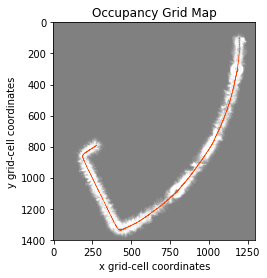

Encoder Counter: 45000
Lidar Counter: 44935
Encoder Counter: 45000
Encoder Counter: 45001
Encoder Counter: 45002
Encoder Counter: 45003
Encoder Counter: 45004
Lidar Counter: 44935
Encoder Counter: 45005
Encoder Counter: 45006
Encoder Counter: 45007
Encoder Counter: 45008
Encoder Counter: 45009
Lidar Counter: 44940
Encoder Counter: 45010
Encoder Counter: 45011
Encoder Counter: 45012
Encoder Counter: 45013
Encoder Counter: 45014
Lidar Counter: 44945
Encoder Counter: 45015
Encoder Counter: 45016
Encoder Counter: 45017
Encoder Counter: 45018
Encoder Counter: 45019
Lidar Counter: 44950
Encoder Counter: 45020
Encoder Counter: 45021
Encoder Counter: 45022
Encoder Counter: 45023
Encoder Counter: 45024
Lidar Counter: 44955
Encoder Counter: 45025
Encoder Counter: 45026
Encoder Counter: 45027
Encoder Counter: 45028
Encoder Counter: 45029
Lidar Counter: 44960
Encoder Counter: 45030
Encoder Counter: 45031
Encoder Counter: 45032
Encoder Counter: 45033
Encoder Counter: 45034
Lidar Counter: 44965
Enco

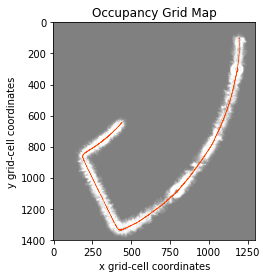

Encoder Counter: 48000
Lidar Counter: 47930
Encoder Counter: 48000
Encoder Counter: 48001
Encoder Counter: 48002
Encoder Counter: 48003
Encoder Counter: 48004
Lidar Counter: 47930
Encoder Counter: 48005
Encoder Counter: 48006
Encoder Counter: 48007
Encoder Counter: 48008
Encoder Counter: 48009
Lidar Counter: 47935
Encoder Counter: 48010
Encoder Counter: 48011
Encoder Counter: 48012
Encoder Counter: 48013
Encoder Counter: 48014
Lidar Counter: 47940
Encoder Counter: 48015
Encoder Counter: 48016
Encoder Counter: 48017
Encoder Counter: 48018
Encoder Counter: 48019
Lidar Counter: 47945
Encoder Counter: 48020
Encoder Counter: 48021
Encoder Counter: 48022
Encoder Counter: 48023
Encoder Counter: 48024
Lidar Counter: 47950
Encoder Counter: 48025
Encoder Counter: 48026
Encoder Counter: 48027
Encoder Counter: 48028
Encoder Counter: 48029
Lidar Counter: 47955
Encoder Counter: 48030
Encoder Counter: 48031
Encoder Counter: 48032
Encoder Counter: 48033
Encoder Counter: 48034
Lidar Counter: 47960
Enco

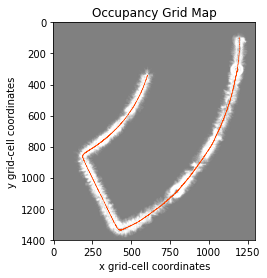

Encoder Counter: 51000
Lidar Counter: 50925
Encoder Counter: 51000
Encoder Counter: 51001
Encoder Counter: 51002
Encoder Counter: 51003
Lidar Counter: 50925
Encoder Counter: 51004
Encoder Counter: 51005
Encoder Counter: 51006
Encoder Counter: 51007
Encoder Counter: 51008
Lidar Counter: 50930
Encoder Counter: 51009
Encoder Counter: 51010
Encoder Counter: 51011
Encoder Counter: 51012
Encoder Counter: 51013
Lidar Counter: 50935
Encoder Counter: 51014
Encoder Counter: 51015
Encoder Counter: 51016
Encoder Counter: 51017
Encoder Counter: 51018
Lidar Counter: 50940
Encoder Counter: 51019
Encoder Counter: 51020
Encoder Counter: 51021
Encoder Counter: 51022
Encoder Counter: 51023
Lidar Counter: 50945
Encoder Counter: 51024
Encoder Counter: 51025
Encoder Counter: 51026
Encoder Counter: 51027
Encoder Counter: 51028
Lidar Counter: 50950
Encoder Counter: 51029
Encoder Counter: 51030
Encoder Counter: 51031
Encoder Counter: 51032
Encoder Counter: 51033
Lidar Counter: 50955
Encoder Counter: 51034
Enco

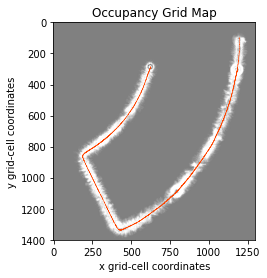

Encoder Counter: 54000
Lidar Counter: 53920
Encoder Counter: 54000
Encoder Counter: 54001
Encoder Counter: 54002
Encoder Counter: 54003
Lidar Counter: 53920
Encoder Counter: 54004
Encoder Counter: 54005
Encoder Counter: 54006
Encoder Counter: 54007
Encoder Counter: 54008
Lidar Counter: 53925
Encoder Counter: 54009
Encoder Counter: 54010
Encoder Counter: 54011
Encoder Counter: 54012
Encoder Counter: 54013
Lidar Counter: 53930
Encoder Counter: 54014
Encoder Counter: 54015
Encoder Counter: 54016
Encoder Counter: 54017
Encoder Counter: 54018
Lidar Counter: 53935
Encoder Counter: 54019
Encoder Counter: 54020
Encoder Counter: 54021
Encoder Counter: 54022
Encoder Counter: 54023
Lidar Counter: 53940
Encoder Counter: 54024
Encoder Counter: 54025
Encoder Counter: 54026
Encoder Counter: 54027
Encoder Counter: 54028
Lidar Counter: 53945
Encoder Counter: 54029
Encoder Counter: 54030
Encoder Counter: 54031
Encoder Counter: 54032
Encoder Counter: 54033
Lidar Counter: 53950
Encoder Counter: 54034
Enco

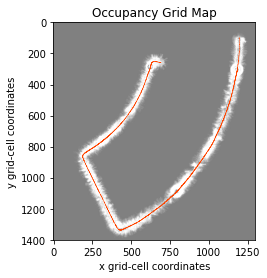

Encoder Counter: 57000
Lidar Counter: 56915
Encoder Counter: 57000
Encoder Counter: 57001
Encoder Counter: 57002
Lidar Counter: 56915
Encoder Counter: 57003
Encoder Counter: 57004
Encoder Counter: 57005
Encoder Counter: 57006
Encoder Counter: 57007
Lidar Counter: 56920
Encoder Counter: 57008
Encoder Counter: 57009
Encoder Counter: 57010
Encoder Counter: 57011
Encoder Counter: 57012
Lidar Counter: 56925
Encoder Counter: 57013
Encoder Counter: 57014
Encoder Counter: 57015
Encoder Counter: 57016
Encoder Counter: 57017
Encoder Counter: 57018
Lidar Counter: 56930
Encoder Counter: 57019
Encoder Counter: 57020
Encoder Counter: 57021
Encoder Counter: 57022
Lidar Counter: 56935
Encoder Counter: 57023
Encoder Counter: 57024
Encoder Counter: 57025
Encoder Counter: 57026
Encoder Counter: 57027
Encoder Counter: 57028
Lidar Counter: 56940
Encoder Counter: 57029
Encoder Counter: 57030
Encoder Counter: 57031
Encoder Counter: 57032
Encoder Counter: 57033
Lidar Counter: 56945
Encoder Counter: 57034
Enco

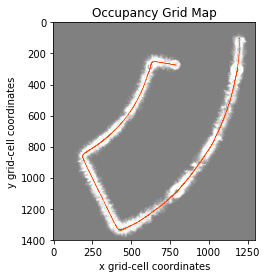

Encoder Counter: 60000
Lidar Counter: 59910
Encoder Counter: 60000
Encoder Counter: 60001
Encoder Counter: 60002
Lidar Counter: 59910
Encoder Counter: 60003
Encoder Counter: 60004
Encoder Counter: 60005
Encoder Counter: 60006
Encoder Counter: 60007
Lidar Counter: 59915
Encoder Counter: 60008
Encoder Counter: 60009
Encoder Counter: 60010
Encoder Counter: 60011
Encoder Counter: 60012
Lidar Counter: 59920
Encoder Counter: 60013
Encoder Counter: 60014
Encoder Counter: 60015
Encoder Counter: 60016
Encoder Counter: 60017
Lidar Counter: 59925
Encoder Counter: 60018
Encoder Counter: 60019
Encoder Counter: 60020
Encoder Counter: 60021
Encoder Counter: 60022
Lidar Counter: 59930
Encoder Counter: 60023
Encoder Counter: 60024
Encoder Counter: 60025
Encoder Counter: 60026
Encoder Counter: 60027
Lidar Counter: 59935
Encoder Counter: 60028
Encoder Counter: 60029
Encoder Counter: 60030
Encoder Counter: 60031
Encoder Counter: 60032
Lidar Counter: 59940
Encoder Counter: 60033
Encoder Counter: 60034
Enco

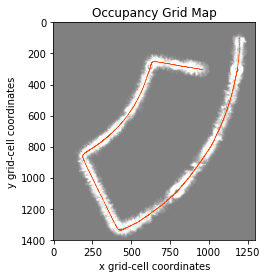

Encoder Counter: 63000
Lidar Counter: 62905
Encoder Counter: 63000
Encoder Counter: 63001
Encoder Counter: 63002
Lidar Counter: 62905
Encoder Counter: 63003
Encoder Counter: 63004
Encoder Counter: 63005
Encoder Counter: 63006
Encoder Counter: 63007
Lidar Counter: 62910
Encoder Counter: 63008
Encoder Counter: 63009
Encoder Counter: 63010
Encoder Counter: 63011
Encoder Counter: 63012
Lidar Counter: 62915
Encoder Counter: 63013
Encoder Counter: 63014
Encoder Counter: 63015
Encoder Counter: 63016
Encoder Counter: 63017
Lidar Counter: 62920
Encoder Counter: 63018
Encoder Counter: 63019
Encoder Counter: 63020
Encoder Counter: 63021
Encoder Counter: 63022
Lidar Counter: 62925
Encoder Counter: 63023
Encoder Counter: 63024
Encoder Counter: 63025
Encoder Counter: 63026
Encoder Counter: 63027
Lidar Counter: 62930
Encoder Counter: 63028
Encoder Counter: 63029
Encoder Counter: 63030
Encoder Counter: 63031
Encoder Counter: 63032
Lidar Counter: 62935
Encoder Counter: 63033
Encoder Counter: 63034
Enco

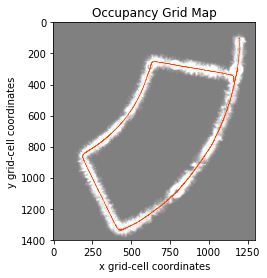

Encoder Counter: 66000
Lidar Counter: 65900
Encoder Counter: 66000
Encoder Counter: 66001
Lidar Counter: 65900
Encoder Counter: 66002
Encoder Counter: 66003
Encoder Counter: 66004
Encoder Counter: 66005
Encoder Counter: 66006
Lidar Counter: 65905
Encoder Counter: 66007
Encoder Counter: 66008
Encoder Counter: 66009
Encoder Counter: 66010
Encoder Counter: 66011
Lidar Counter: 65910
Encoder Counter: 66012
Encoder Counter: 66013
Encoder Counter: 66014
Encoder Counter: 66015
Encoder Counter: 66016
Lidar Counter: 65915
Encoder Counter: 66017
Encoder Counter: 66018
Encoder Counter: 66019
Encoder Counter: 66020
Encoder Counter: 66021
Lidar Counter: 65920
Encoder Counter: 66022
Encoder Counter: 66023
Encoder Counter: 66024
Encoder Counter: 66025
Encoder Counter: 66026
Lidar Counter: 65925
Encoder Counter: 66027
Encoder Counter: 66028
Encoder Counter: 66029
Encoder Counter: 66030
Encoder Counter: 66031
Lidar Counter: 65930
Encoder Counter: 66032
Encoder Counter: 66033
Encoder Counter: 66034
Enco

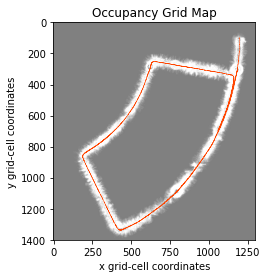

Encoder Counter: 69000
Lidar Counter: 68895
Encoder Counter: 69000
Encoder Counter: 69001
Lidar Counter: 68895
Encoder Counter: 69002
Encoder Counter: 69003
Encoder Counter: 69004
Encoder Counter: 69005
Encoder Counter: 69006
Lidar Counter: 68900
Encoder Counter: 69007
Encoder Counter: 69008
Encoder Counter: 69009
Encoder Counter: 69010
Encoder Counter: 69011
Lidar Counter: 68905
Encoder Counter: 69012
Encoder Counter: 69013
Encoder Counter: 69014
Encoder Counter: 69015
Encoder Counter: 69016
Lidar Counter: 68910
Encoder Counter: 69017
Encoder Counter: 69018
Encoder Counter: 69019
Encoder Counter: 69020
Encoder Counter: 69021
Lidar Counter: 68915
Encoder Counter: 69022
Encoder Counter: 69023
Encoder Counter: 69024
Encoder Counter: 69025
Encoder Counter: 69026
Lidar Counter: 68920
Encoder Counter: 69027
Encoder Counter: 69028
Encoder Counter: 69029
Encoder Counter: 69030
Encoder Counter: 69031
Lidar Counter: 68925
Encoder Counter: 69032
Encoder Counter: 69033
Encoder Counter: 69034
Enco

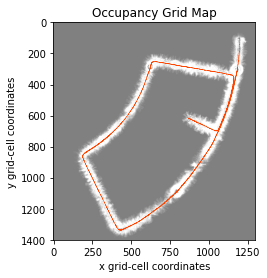

Encoder Counter: 72000
Lidar Counter: 71890
Encoder Counter: 72000
Encoder Counter: 72001
Lidar Counter: 71890
Encoder Counter: 72002
Encoder Counter: 72003
Encoder Counter: 72004
Encoder Counter: 72005
Encoder Counter: 72006
Lidar Counter: 71895
Encoder Counter: 72007
Encoder Counter: 72008
Encoder Counter: 72009
Encoder Counter: 72010
Encoder Counter: 72011
Lidar Counter: 71900
Encoder Counter: 72012
Encoder Counter: 72013
Encoder Counter: 72014
Encoder Counter: 72015
Encoder Counter: 72016
Lidar Counter: 71905
Encoder Counter: 72017
Encoder Counter: 72018
Encoder Counter: 72019
Encoder Counter: 72020
Encoder Counter: 72021
Lidar Counter: 71910
Encoder Counter: 72022
Encoder Counter: 72023
Encoder Counter: 72024
Encoder Counter: 72025
Encoder Counter: 72026
Lidar Counter: 71915
Encoder Counter: 72027
Encoder Counter: 72028
Encoder Counter: 72029
Encoder Counter: 72030
Encoder Counter: 72031
Lidar Counter: 71920
Encoder Counter: 72032
Encoder Counter: 72033
Encoder Counter: 72034
Enco

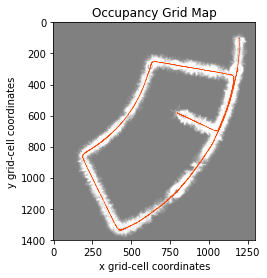

Encoder Counter: 75000
Lidar Counter: 74885
Encoder Counter: 75000
Lidar Counter: 74885
Encoder Counter: 75001
Encoder Counter: 75002
Encoder Counter: 75003
Encoder Counter: 75004
Encoder Counter: 75005
Lidar Counter: 74890
Encoder Counter: 75006
Encoder Counter: 75007
Encoder Counter: 75008
Encoder Counter: 75009
Encoder Counter: 75010
Lidar Counter: 74895
Encoder Counter: 75011
Encoder Counter: 75012
Encoder Counter: 75013
Encoder Counter: 75014
Encoder Counter: 75015
Lidar Counter: 74900
Encoder Counter: 75016
Encoder Counter: 75017
Encoder Counter: 75018
Encoder Counter: 75019
Encoder Counter: 75020
Lidar Counter: 74905
Encoder Counter: 75021
Encoder Counter: 75022
Encoder Counter: 75023
Encoder Counter: 75024
Encoder Counter: 75025
Lidar Counter: 74910
Encoder Counter: 75026
Encoder Counter: 75027
Encoder Counter: 75028
Encoder Counter: 75029
Encoder Counter: 75030
Lidar Counter: 74915
Encoder Counter: 75031
Encoder Counter: 75032
Encoder Counter: 75033
Encoder Counter: 75034
Enco

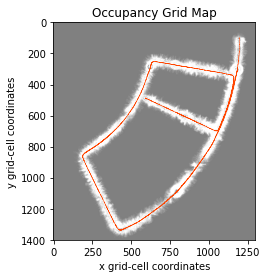

Encoder Counter: 78000
Lidar Counter: 77880
Encoder Counter: 78000
Lidar Counter: 77880
Encoder Counter: 78001
Encoder Counter: 78002
Encoder Counter: 78003
Encoder Counter: 78004
Encoder Counter: 78005
Lidar Counter: 77885
Encoder Counter: 78006
Encoder Counter: 78007
Encoder Counter: 78008
Encoder Counter: 78009
Encoder Counter: 78010
Lidar Counter: 77890
Encoder Counter: 78011
Encoder Counter: 78012
Encoder Counter: 78013
Encoder Counter: 78014
Encoder Counter: 78015
Lidar Counter: 77895
Encoder Counter: 78016
Encoder Counter: 78017
Encoder Counter: 78018
Encoder Counter: 78019
Encoder Counter: 78020
Lidar Counter: 77900
Encoder Counter: 78021
Encoder Counter: 78022
Encoder Counter: 78023
Encoder Counter: 78024
Encoder Counter: 78025
Lidar Counter: 77905
Encoder Counter: 78026
Encoder Counter: 78027
Encoder Counter: 78028
Encoder Counter: 78029
Encoder Counter: 78030
Lidar Counter: 77910
Encoder Counter: 78031
Encoder Counter: 78032
Encoder Counter: 78033
Encoder Counter: 78034
Enco

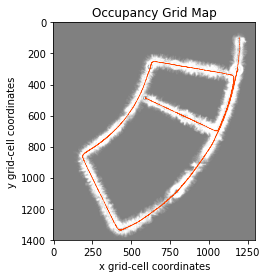

Encoder Counter: 81000
Lidar Counter: 80875
Encoder Counter: 81000
Lidar Counter: 80875
Encoder Counter: 81001
Encoder Counter: 81002
Encoder Counter: 81003
Encoder Counter: 81004
Encoder Counter: 81005
Lidar Counter: 80880
Encoder Counter: 81006
Encoder Counter: 81007
Encoder Counter: 81008
Encoder Counter: 81009
Encoder Counter: 81010
Lidar Counter: 80885
Encoder Counter: 81011
Encoder Counter: 81012
Encoder Counter: 81013
Encoder Counter: 81014
Encoder Counter: 81015
Lidar Counter: 80890
Encoder Counter: 81016
Encoder Counter: 81017
Encoder Counter: 81018
Encoder Counter: 81019
Encoder Counter: 81020
Lidar Counter: 80895
Encoder Counter: 81021
Encoder Counter: 81022
Encoder Counter: 81023
Encoder Counter: 81024
Encoder Counter: 81025
Lidar Counter: 80900
Encoder Counter: 81026
Encoder Counter: 81027
Encoder Counter: 81028
Encoder Counter: 81029
Encoder Counter: 81030
Lidar Counter: 80905
Encoder Counter: 81031
Encoder Counter: 81032
Encoder Counter: 81033
Encoder Counter: 81034
Enco

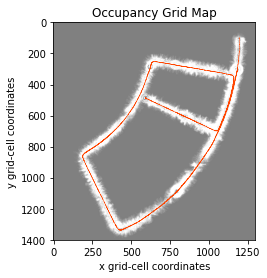

Encoder Counter: 84000
Lidar Counter: 83875
Encoder Counter: 84000
Encoder Counter: 84001
Encoder Counter: 84002
Encoder Counter: 84003
Encoder Counter: 84004
Lidar Counter: 83875
Encoder Counter: 84005
Encoder Counter: 84006
Encoder Counter: 84007
Encoder Counter: 84008
Encoder Counter: 84009
Lidar Counter: 83880
Encoder Counter: 84010
Encoder Counter: 84011
Encoder Counter: 84012
Encoder Counter: 84013
Encoder Counter: 84014
Lidar Counter: 83885
Encoder Counter: 84015
Encoder Counter: 84016
Encoder Counter: 84017
Encoder Counter: 84018
Encoder Counter: 84019
Lidar Counter: 83890
Encoder Counter: 84020
Encoder Counter: 84021
Encoder Counter: 84022
Encoder Counter: 84023
Encoder Counter: 84024
Lidar Counter: 83895
Encoder Counter: 84025
Encoder Counter: 84026
Encoder Counter: 84027
Encoder Counter: 84028
Encoder Counter: 84029
Lidar Counter: 83900
Encoder Counter: 84030
Encoder Counter: 84031
Encoder Counter: 84032
Encoder Counter: 84033
Encoder Counter: 84034
Lidar Counter: 83905
Enco

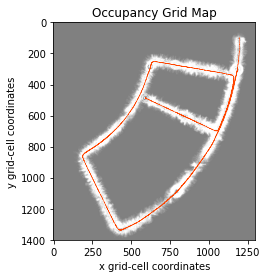

Encoder Counter: 87000
Lidar Counter: 86870
Encoder Counter: 87000
Encoder Counter: 87001
Encoder Counter: 87002
Encoder Counter: 87003
Encoder Counter: 87004
Lidar Counter: 86870
Encoder Counter: 87005
Encoder Counter: 87006
Encoder Counter: 87007
Encoder Counter: 87008
Encoder Counter: 87009
Lidar Counter: 86875
Encoder Counter: 87010
Encoder Counter: 87011
Encoder Counter: 87012
Encoder Counter: 87013
Encoder Counter: 87014
Lidar Counter: 86880
Encoder Counter: 87015
Encoder Counter: 87016
Encoder Counter: 87017
Encoder Counter: 87018
Encoder Counter: 87019
Lidar Counter: 86885
Encoder Counter: 87020
Encoder Counter: 87021
Encoder Counter: 87022
Encoder Counter: 87023
Encoder Counter: 87024
Lidar Counter: 86890
Encoder Counter: 87025
Encoder Counter: 87026
Encoder Counter: 87027
Encoder Counter: 87028
Encoder Counter: 87029
Lidar Counter: 86895
Encoder Counter: 87030
Encoder Counter: 87031
Encoder Counter: 87032
Encoder Counter: 87033
Encoder Counter: 87034
Lidar Counter: 86900
Enco

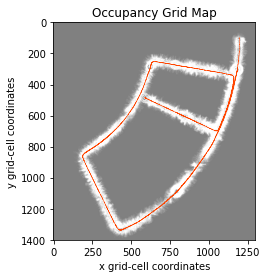

Encoder Counter: 90000
Lidar Counter: 89865
Encoder Counter: 90000
Encoder Counter: 90001
Encoder Counter: 90002
Encoder Counter: 90003
Encoder Counter: 90004
Lidar Counter: 89865
Encoder Counter: 90005
Encoder Counter: 90006
Encoder Counter: 90007
Encoder Counter: 90008
Encoder Counter: 90009
Lidar Counter: 89870
Encoder Counter: 90010
Encoder Counter: 90011
Encoder Counter: 90012
Encoder Counter: 90013
Encoder Counter: 90014
Lidar Counter: 89875
Encoder Counter: 90015
Encoder Counter: 90016
Encoder Counter: 90017
Encoder Counter: 90018
Encoder Counter: 90019
Lidar Counter: 89880
Encoder Counter: 90020
Encoder Counter: 90021
Encoder Counter: 90022
Encoder Counter: 90023
Encoder Counter: 90024
Lidar Counter: 89885
Encoder Counter: 90025
Encoder Counter: 90026
Encoder Counter: 90027
Encoder Counter: 90028
Encoder Counter: 90029
Lidar Counter: 89890
Encoder Counter: 90030
Encoder Counter: 90031
Encoder Counter: 90032
Encoder Counter: 90033
Encoder Counter: 90034
Lidar Counter: 89895
Enco

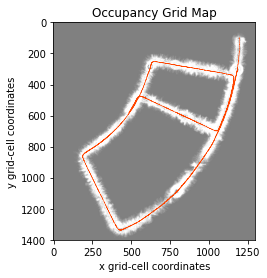

Encoder Counter: 93000
Lidar Counter: 92860
Encoder Counter: 93000
Encoder Counter: 93001
Encoder Counter: 93002
Encoder Counter: 93003
Lidar Counter: 92860
Encoder Counter: 93004
Encoder Counter: 93005
Encoder Counter: 93006
Encoder Counter: 93007
Encoder Counter: 93008
Lidar Counter: 92865
Encoder Counter: 93009
Encoder Counter: 93010
Encoder Counter: 93011
Encoder Counter: 93012
Encoder Counter: 93013
Lidar Counter: 92870
Encoder Counter: 93014
Encoder Counter: 93015
Encoder Counter: 93016
Encoder Counter: 93017
Encoder Counter: 93018
Lidar Counter: 92875
Encoder Counter: 93019
Encoder Counter: 93020
Encoder Counter: 93021
Encoder Counter: 93022
Encoder Counter: 93023
Lidar Counter: 92880
Encoder Counter: 93024
Encoder Counter: 93025
Encoder Counter: 93026
Encoder Counter: 93027
Encoder Counter: 93028
Lidar Counter: 92885
Encoder Counter: 93029
Encoder Counter: 93030
Encoder Counter: 93031
Encoder Counter: 93032
Encoder Counter: 93033
Lidar Counter: 92890
Encoder Counter: 93034
Enco

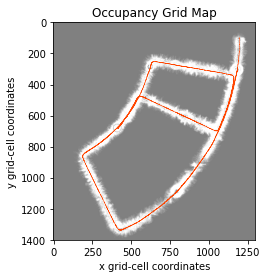

Encoder Counter: 96000
Lidar Counter: 95855
Encoder Counter: 96000
Encoder Counter: 96001
Encoder Counter: 96002
Encoder Counter: 96003
Lidar Counter: 95855
Encoder Counter: 96004
Encoder Counter: 96005
Encoder Counter: 96006
Encoder Counter: 96007
Encoder Counter: 96008
Lidar Counter: 95860
Encoder Counter: 96009
Encoder Counter: 96010
Encoder Counter: 96011
Encoder Counter: 96012
Encoder Counter: 96013
Lidar Counter: 95865
Encoder Counter: 96014
Encoder Counter: 96015
Encoder Counter: 96016
Encoder Counter: 96017
Encoder Counter: 96018
Lidar Counter: 95870
Encoder Counter: 96019
Encoder Counter: 96020
Encoder Counter: 96021
Encoder Counter: 96022
Encoder Counter: 96023
Lidar Counter: 95875
Encoder Counter: 96024
Encoder Counter: 96025
Encoder Counter: 96026
Encoder Counter: 96027
Encoder Counter: 96028
Lidar Counter: 95880
Encoder Counter: 96029
Encoder Counter: 96030
Encoder Counter: 96031
Encoder Counter: 96032
Encoder Counter: 96033
Lidar Counter: 95885
Encoder Counter: 96034
Enco

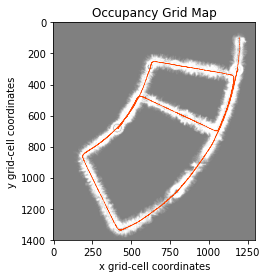

Encoder Counter: 99000
Lidar Counter: 98850
Encoder Counter: 99000
Encoder Counter: 99001
Encoder Counter: 99002
Lidar Counter: 98850
Encoder Counter: 99003
Encoder Counter: 99004
Encoder Counter: 99005
Encoder Counter: 99006
Encoder Counter: 99007
Lidar Counter: 98855
Encoder Counter: 99008
Encoder Counter: 99009
Encoder Counter: 99010
Encoder Counter: 99011
Encoder Counter: 99012
Encoder Counter: 99013
Lidar Counter: 98860
Encoder Counter: 99014
Encoder Counter: 99015
Encoder Counter: 99016
Encoder Counter: 99017
Lidar Counter: 98865
Encoder Counter: 99018
Encoder Counter: 99019
Encoder Counter: 99020
Encoder Counter: 99021
Encoder Counter: 99022
Encoder Counter: 99023
Lidar Counter: 98870
Encoder Counter: 99024
Encoder Counter: 99025
Encoder Counter: 99026
Encoder Counter: 99027
Encoder Counter: 99028
Lidar Counter: 98875
Encoder Counter: 99029
Encoder Counter: 99030
Encoder Counter: 99031
Encoder Counter: 99032
Encoder Counter: 99033
Lidar Counter: 98880
Encoder Counter: 99034
Enco

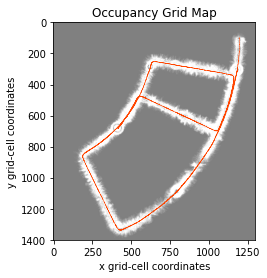

Encoder Counter: 102000
Lidar Counter: 101845
Encoder Counter: 102000
Encoder Counter: 102001
Encoder Counter: 102002
Lidar Counter: 101845
Encoder Counter: 102003
Encoder Counter: 102004
Encoder Counter: 102005
Encoder Counter: 102006
Encoder Counter: 102007
Lidar Counter: 101850
Encoder Counter: 102008
Encoder Counter: 102009
Encoder Counter: 102010
Encoder Counter: 102011
Encoder Counter: 102012
Lidar Counter: 101855
Encoder Counter: 102013
Encoder Counter: 102014
Encoder Counter: 102015
Encoder Counter: 102016
Encoder Counter: 102017
Lidar Counter: 101860
Encoder Counter: 102018
Encoder Counter: 102019
Encoder Counter: 102020
Encoder Counter: 102021
Encoder Counter: 102022
Lidar Counter: 101865
Encoder Counter: 102023
Encoder Counter: 102024
Encoder Counter: 102025
Encoder Counter: 102026
Encoder Counter: 102027
Lidar Counter: 101870
Encoder Counter: 102028
Encoder Counter: 102029
Encoder Counter: 102030
Encoder Counter: 102031
Encoder Counter: 102032
Lidar Counter: 101875
Encoder 

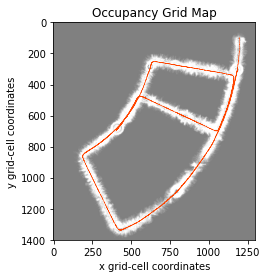

Encoder Counter: 105000
Lidar Counter: 104840
Encoder Counter: 105000
Encoder Counter: 105001
Encoder Counter: 105002
Lidar Counter: 104840
Encoder Counter: 105003
Encoder Counter: 105004
Encoder Counter: 105005
Encoder Counter: 105006
Encoder Counter: 105007
Lidar Counter: 104845
Encoder Counter: 105008
Encoder Counter: 105009
Encoder Counter: 105010
Encoder Counter: 105011
Encoder Counter: 105012
Lidar Counter: 104850
Encoder Counter: 105013
Encoder Counter: 105014
Encoder Counter: 105015
Encoder Counter: 105016
Encoder Counter: 105017
Lidar Counter: 104855
Encoder Counter: 105018
Encoder Counter: 105019
Encoder Counter: 105020
Encoder Counter: 105021
Encoder Counter: 105022
Lidar Counter: 104860
Encoder Counter: 105023
Encoder Counter: 105024
Encoder Counter: 105025
Encoder Counter: 105026
Encoder Counter: 105027
Lidar Counter: 104865
Encoder Counter: 105028
Encoder Counter: 105029
Encoder Counter: 105030
Encoder Counter: 105031
Encoder Counter: 105032
Lidar Counter: 104870
Encoder 

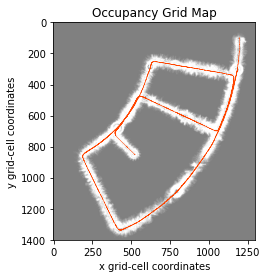

Encoder Counter: 108000
Lidar Counter: 107835
Encoder Counter: 108000
Encoder Counter: 108001
Lidar Counter: 107835
Encoder Counter: 108002
Encoder Counter: 108003
Encoder Counter: 108004
Encoder Counter: 108005
Encoder Counter: 108006
Lidar Counter: 107840
Encoder Counter: 108007
Encoder Counter: 108008
Encoder Counter: 108009
Encoder Counter: 108010
Encoder Counter: 108011
Lidar Counter: 107845
Encoder Counter: 108012
Encoder Counter: 108013
Encoder Counter: 108014
Encoder Counter: 108015
Encoder Counter: 108016
Lidar Counter: 107850
Encoder Counter: 108017
Encoder Counter: 108018
Encoder Counter: 108019
Encoder Counter: 108020
Encoder Counter: 108021
Lidar Counter: 107855
Encoder Counter: 108022
Encoder Counter: 108023
Encoder Counter: 108024
Encoder Counter: 108025
Encoder Counter: 108026
Lidar Counter: 107860
Encoder Counter: 108027
Encoder Counter: 108028
Encoder Counter: 108029
Encoder Counter: 108030
Encoder Counter: 108031
Lidar Counter: 107865
Encoder Counter: 108032
Encoder 

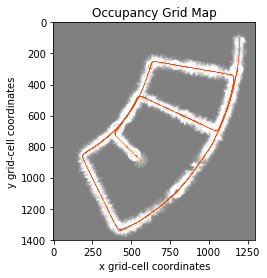

Encoder Counter: 111000
Lidar Counter: 110830
Encoder Counter: 111000
Encoder Counter: 111001
Lidar Counter: 110830
Encoder Counter: 111002
Encoder Counter: 111003
Encoder Counter: 111004
Encoder Counter: 111005
Encoder Counter: 111006
Lidar Counter: 110835
Encoder Counter: 111007
Encoder Counter: 111008
Encoder Counter: 111009
Encoder Counter: 111010
Encoder Counter: 111011
Lidar Counter: 110840
Encoder Counter: 111012
Encoder Counter: 111013
Encoder Counter: 111014
Encoder Counter: 111015
Encoder Counter: 111016
Lidar Counter: 110845
Encoder Counter: 111017
Encoder Counter: 111018
Encoder Counter: 111019
Encoder Counter: 111020
Encoder Counter: 111021
Lidar Counter: 110850
Encoder Counter: 111022
Encoder Counter: 111023
Encoder Counter: 111024
Encoder Counter: 111025
Encoder Counter: 111026
Lidar Counter: 110855
Encoder Counter: 111027
Encoder Counter: 111028
Encoder Counter: 111029
Encoder Counter: 111030
Encoder Counter: 111031
Lidar Counter: 110860
Encoder Counter: 111032
Encoder 

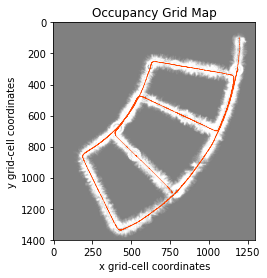

Encoder Counter: 114000
Lidar Counter: 113825
Encoder Counter: 114000
Encoder Counter: 114001
Lidar Counter: 113825
Encoder Counter: 114002
Encoder Counter: 114003
Encoder Counter: 114004
Encoder Counter: 114005
Encoder Counter: 114006
Lidar Counter: 113830
Encoder Counter: 114007
Encoder Counter: 114008
Encoder Counter: 114009
Encoder Counter: 114010
Encoder Counter: 114011
Lidar Counter: 113835
Encoder Counter: 114012
Encoder Counter: 114013
Encoder Counter: 114014
Encoder Counter: 114015
Encoder Counter: 114016
Lidar Counter: 113840
Encoder Counter: 114017
Encoder Counter: 114018
Encoder Counter: 114019
Encoder Counter: 114020
Encoder Counter: 114021
Lidar Counter: 113845
Encoder Counter: 114022
Encoder Counter: 114023
Encoder Counter: 114024
Encoder Counter: 114025
Encoder Counter: 114026
Lidar Counter: 113850
Encoder Counter: 114027
Encoder Counter: 114028
Encoder Counter: 114029
Encoder Counter: 114030
Encoder Counter: 114031
Lidar Counter: 113855
Encoder Counter: 114032
Encoder 

TypeError: superimpose_Trajectory() missing 1 required positional argument: 'MAP'

In [6]:



import numpy as np
import matplotlib.pyplot as plt
from pr2_utils import *
# from process_lidar_data import process_Lidar_Data
# from utility import *

# Variable Definitions

MAP                 = {}
log_Odds_Ratio      = np.log(4)
delta_Yaw           = np.zeros(116048)
dt                  = np.zeros(116048)
X                   = np.zeros((116048, 3))
X[0]                = np.array([0,0,0]) # Initializing the first element of X at 0
trajectory          = np.zeros((1,2))
theta               = 0 # General variable for angle
encoder_Counter     = 0
lidar_Counter       = 0

# Encoder Parameters

left_Wheel_Dia      = 0.623479 # Meters
right_Wheel_Dia     = 0.622806 # Meters
enc_Resolution      = 4096

# Particles Parameters

particle_Count      = 3
particle_Weights    = np.zeros((1, particle_Count))
particle_State      = np.zeros((particle_Count, 3))

# Main Code starts from here

# Load Data for all the sensors
timestamp_Lidar, data_Lidar             = initialize_Lidar()
timestamp_Encoder, data_Encoder         = initialize_Encoder()
timestamp_FOG, data_FOG                 = initialize_FOG()

# Initialize MAP
MAP, x_im, y_im, x_range, y_range       = initialize_Map(MAP)

# Sync Encoder and FOG Data
delta_Yaw, dt                           = sync_Encoder_FOG_Data(data_FOG, timestamp_Encoder)

# Initialize Particle Weights
particle_Weights[0, 0:particle_Count]   = 1/particle_Count

# Update Map with the first Lidar Scan
xs0, ys0                                = lidar_data_process( data_Lidar[lidar_Counter,:], X[0] )
MAP                                     = update_Map( MAP, xs0, ys0, X[0], log_Odds_Ratio )

# Main Loop
for encoder_Counter in range( len( timestamp_Encoder ) - 1 ):

    left_Wheel_Distance     = ( (data_Encoder[encoder_Counter+1, 0] - data_Encoder[encoder_Counter, 0]) * np.pi * left_Wheel_Dia )/ enc_Resolution
    right_Wheel_Distance    = ( (data_Encoder[encoder_Counter+1, 1] - data_Encoder[encoder_Counter, 1]) * np.pi * right_Wheel_Dia )/ enc_Resolution

    delta_distance          = ( left_Wheel_Distance + right_Wheel_Distance ) / 2

    theta                   = theta + delta_Yaw[encoder_Counter]
    #X[encoder_Counter+1]    = X[encoder_Counter] + np.array( [ delta_distance * np.cos(theta), delta_distance * np.sin(theta), theta ])
    particle_State          = particle_State + np.array( [ delta_distance * np.cos(theta), delta_distance * np.sin(theta), theta ])
    particle_State          = add_Noise( particle_State, particle_Count, dt[encoder_Counter] )

    if timestamp_Lidar[lidar_Counter] < timestamp_Encoder[encoder_Counter]:

        state_Matched_Particle      = calculate_Map_Correlation(data_Lidar[lidar_Counter,:], particle_Count, particle_State, particle_Weights, MAP, x_im, y_im, x_range, y_range)
        xs0, ys0                    = lidar_data_process( data_Lidar[lidar_Counter,:], state_Matched_Particle )
        MAP                         = update_Map( MAP, xs0, ys0, state_Matched_Particle, log_Odds_Ratio )

        # Uncomment these lines to run without the particles
        # xs0, ys0                    = process_Lidar_Data( data_Lidar[lidar_Counter,:], X[encoder_Counter] )
        # MAP                         = update_Map( MAP, xs0, ys0, X[encoder_Counter], log_Odds_Ratio )

        print('Lidar Counter:', lidar_Counter)
        lidar_Counter               += 5

    # Save Trajectory
    X[encoder_Counter]      = state_Matched_Particle
    trajectory              = np.concatenate( ( trajectory, np.array( [[X[encoder_Counter,0], X[encoder_Counter,1]]] ) ), axis = 0 )

    if (lidar_Counter == len(data_Lidar)):
        break

    if encoder_Counter % 3000 == 0:

        x,y = superimpose_Trajectory(trajectory, MAP)
        plot_Map(MAP, x,y)
        print('Encoder Counter:', encoder_Counter)
        print('Lidar Counter:', lidar_Counter)

    print('Encoder Counter:', encoder_Counter)

# Plot the Final Map
X = X[~np.all(X == 0, axis=1)]
x,y = superimpose_Trajectory(X, MAP)
plot_Map(MAP, y, x)